#### Для корректной работы нужно
* переместить файлы test.csv & train.csv в директорию data/
* скачать [graphviz](http://www.graphviz.org/download)  
* вылетает ошибка [“dot.exe” not found in path](https://stackoverflow.com/questions/40632486/dot-exe-not-found-in-path-pydot-on-python-windows-7)

In [1]:
import pandas as pd
import sys
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, roc_auc_score,precision_score,accuracy_score,roc_curve,make_scorer
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

In [33]:
train = pd.read_csv('data/train.csv')
train.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,total_acc,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,record_id
0,15000.0,36 months,11.99,498.15,B,B3,Quality Assurance Specialist,4 years,MORTGAGE,70000.0,...,32.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,295215.0,20500.0,453246940
1,3725.0,36 months,6.03,113.38,A,A1,NaN,NaN,MORTGAGE,52260.0,...,9.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,25130.0,14200.0,453313687
2,16000.0,36 months,11.14,524.89,B,B2,KIPP NYC,3 years,RENT,67500.0,...,22.0,f,0.0,1.0,INDIVIDUAL,0.0,193.0,41737.0,19448.0,453283543
3,4200.0,36 months,13.33,142.19,C,C3,Receptionist,< 1 year,MORTGAGE,21600.0,...,19.0,w,0.0,1.0,INDIVIDUAL,0.0,165.0,28187.0,14500.0,453447199
4,6500.0,36 months,12.69,218.05,B,B5,Medtox Laboratories,10+ years,RENT,41000.0,...,12.0,f,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,453350283


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 36 columns):
loan_amnt                     200189 non-null float64
term                          200189 non-null object
int_rate                      200189 non-null float64
installment                   200189 non-null float64
grade                         200189 non-null object
sub_grade                     200189 non-null object
emp_title                     189062 non-null object
emp_length                    192135 non-null object
home_ownership                200189 non-null object
annual_inc                    200189 non-null float64
verification_status           200189 non-null object
issue_d                       200189 non-null object
loan_status                   200189 non-null int64
pymnt_plan                    200189 non-null object
purpose                       200189 non-null object
zip_code                      200189 non-null object
addr_state                    200189 n

* int_rate - Interest Rate on the loan
* annual_inc - Theannual income provided by the borrower during registration
* inq_last_6mths -The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
* mths_since_last_delinq  - Months since most recent personal finance delinquency.
* pub_rec  - Number of derogatory public records
* revolBal - Total credit revolving balance
* revolUtil - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* loan_amnt  - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* installment - The monthly payment owed by the borrower if the loan originates.
* home_ownership    
* emp_title                   
* annual_inc                  
* verification_status  - Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified
* purpose                 
* dti -  A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* open_acc                  
* total_acc                    
* initial_list_status - The initial listing status of the loan. Possible values are – W, F           
* collections_12_mths_ex_med - Number of collections in 12 months excluding medical collections
* application_type - Indicates whether the loan is an individual application or a joint application with two co-borrowers
* acc_now_delinq - The number of accounts on which the borrower is now delinquent.


## Анализ и визуализация данных

In [35]:
aim = train['loan_status'] # целевой признак
others = train.loc[:,['annual_inc','verification_status','int_rate','initial_list_status','term',
                 'installment','open_acc','total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths','total_rev_hi_lim',
                 'revol_bal','revol_util',
                 'tot_coll_amt','loan_amnt'] ]# параметры

In [36]:
others.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [37]:
Nan_killer(others, num = 0)

In [38]:
others.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            200189 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       200189 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

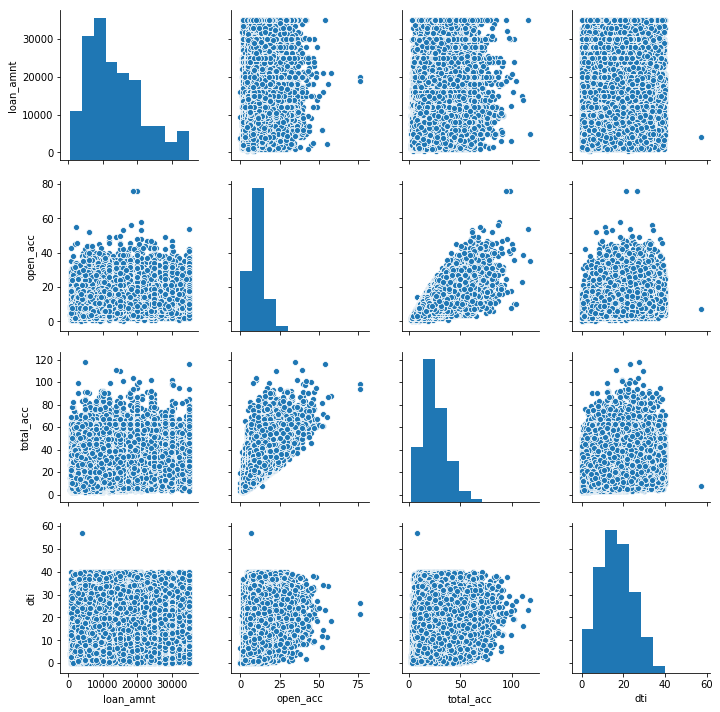

In [39]:
cols = ['loan_amnt',  'open_acc', 'total_acc', 'dti']
sns_plot = sns.pairplot(others[cols])

In [40]:
corr_matrix = others.drop(list(others.columns[others.dtypes == 'object']), axis=1).corr()

In [41]:
corr_matrix

,annual_inc,int_rate,installment,open_acc,total_acc,dti,tot_cur_bal,inq_last_6mths,total_rev_hi_lim,revol_bal,revol_util,tot_coll_amt,loan_amnt
annual_inc,1.000000,-0.027436,0.339094,0.143083,0.209921,-0.175599,0.377980,0.057436,0.268325,0.320178,0.023723,0.005441,0.344462
int_rate,-0.027436,1.000000,0.206644,0.041238,-0.011502,0.178122,-0.001475,0.212601,-0.047586,0.020464,0.331721,0.005966,0.216472
installment,0.339094,0.206644,1.000000,0.199681,0.216059,0.053766,0.292476,0.025670,0.323554,0.332390,0.129979,-0.015226,0.954744
open_acc,0.143083,0.041238,0.199681,1.000000,0.671889,0.306524,0.249709,0.115899,0.351871,0.234050,-0.108343,0.007064,0.204473
total_acc,0.209921,-0.011502,0.216059,0.671889,1.000000,0.229072,0.297077,0.140343,0.282630,0.210240,-0.088651,0.030096,0.234472
dti,-0.175599,0.178122,0.053766,0.306524,0.229072,1.000000,0.054610,-0.000846,0.125916,0.156204,0.219544,-0.020154,0.054016
tot_cur_bal,0.377980,-0.001475,0.292476,0.249709,0.297077,0.054610,1.000000,0.046861,0.507130,0.373497,0.074267,0.001149,0.312455
inq_last_6mths,0.057436,0.212601,0.025670,0.115899,0.140343,-0.000846,0.046861,1.000000,0.018674,-0.013295,-0.091625,0.012351,0.008532
total_rev_hi_lim,0.268325,-0.047586,0.323554,0.351871,0.282630,0.125916,0.507130,0.018674,1.000000,0.691546,-0.089591,-0.024860,0.339488
revol_bal,0.320178,0.020464,0.332390,0.234050,0.210240,0.156204,0.373497,-0.013295,0.691546,1.000000,0.239434,-0.027422,0.341718


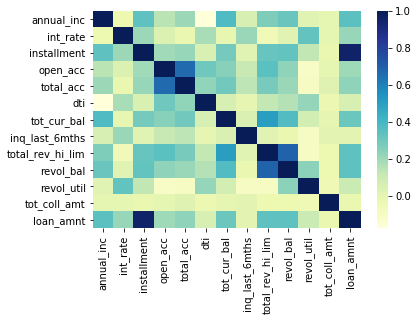

In [42]:
sns.heatmap(corr_matrix,cmap="YlGnBu");

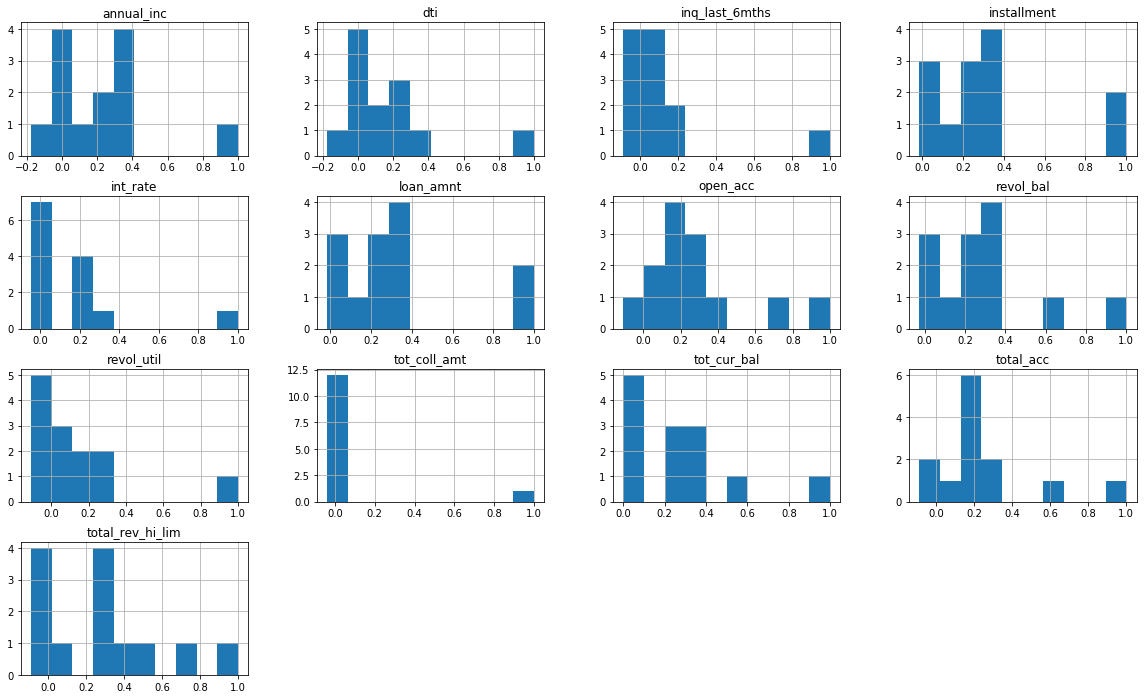

In [43]:
features = others.drop(list(others.columns[others.dtypes == 'object']), axis=1).corr()
features.hist(figsize=(20,12));

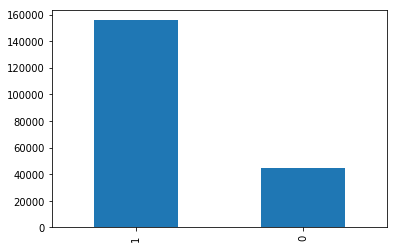

In [44]:
aim.value_counts().plot(kind='bar', label='loan_status')

In [49]:
others.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            200189 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       200189 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

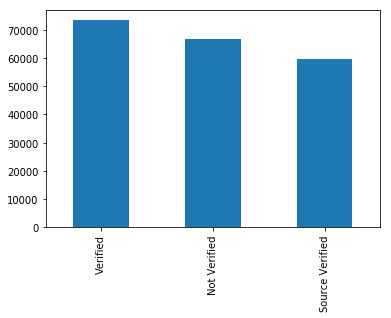

In [50]:
others['verification_status'].value_counts().plot(kind='bar', label='verification_status ')

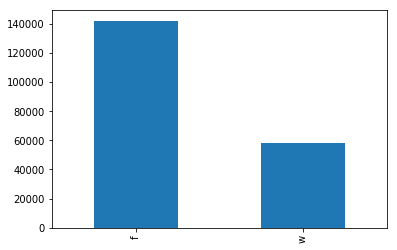

In [51]:
others['initial_list_status'].value_counts().plot(kind='bar', label='initial_list_status')

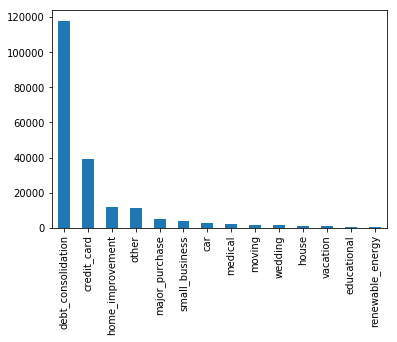

In [52]:
others['purpose'].value_counts().plot(kind='bar', label='purpose')

## Начальная обработка данных:

In [7]:
def Nan_killer(x, num = -999):
    x['revol_util'] = x['revol_util'].fillna(num)
  #  x['tot_coll_amt'] = x['tot_coll_amt'].fillna(num)
    x['tot_cur_bal'] =  x['tot_cur_bal'].fillna(num)
    x['total_rev_hi_lim'] =  x['total_rev_hi_lim'].fillna(num)
    

In [54]:
def proc(x,y):
    x['home_ownership'] = x['home_ownership'].astype(str).map(lambda x: 'OTHER' if x in ['NONE', 'ANY'] else x)
    x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
    x_test['sub_grade'] = x_test['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
    x_train['sub_grade'] = x_train['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
    x_train = pd.get_dummies(x_train, columns = ['purpose','home_ownership','term','verification_status'])   # OHE (?????)
    x_test = pd.get_dummies(x_test, columns = ['purpose','home_ownership','term','verification_status'])
    for i in list(x_test): # удаление из тестовых данных столбцов, если их не было в тренировочных
        if i not in list(x_train):
            list(my_dataframe)
            x_test.drop(i, axis=1, inplace=True)
    for i in list(x_train): # добавление колонки с нулями, если такой нет в тестовой
        if i not in list(x_test):
            x_test[i] = 0
    

    x_test = x_test.reindex(sorted(x_test.columns), axis=1)
    x_train = x_train.reindex(sorted(x_test.columns), axis=1)
    return x_train, x_test, y_train, y_test

## Функция для отображения метрик:
* ROC-AUC
* precision
* recall
* accuracy

In [65]:

def show_scores(model, x_test, y_test):
    pred =  model.predict(x_test)
    print('Recall: %.2f' % recall_score(y_test,pred))
    print('Precision score: %.2f' % precision_score(y_test,pred))
    print('Accuracy score: %.2f' % accuracy_score(y_test, pred))
 

In [66]:
def plot_roc(model, x_test, y_test):  
    pred = model.predict_proba(x_test)
    print("ROC-AUC score: ", roc_auc_score(y_test, pred[:, 1]))
    fpr, tpr,_=roc_curve(y_test,pred[:, 1],drop_intermediate=True)
    plt.figure()
    plt.plot(fpr, tpr, color='red',
            lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

# Регрессия

In [38]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

In [191]:
y = train[train['int_rate'] >= 0]['int_rate'] # целевой признак
x = train.loc[:,['annual_inc','collections_12_mths_ex_med','initial_list_status',
                 'installment','open_acc','total_acc','dti','purpose',
                 'grade','home_ownership','inq_last_6mths','pub_rec','revol_bal','revol_util','loan_status',
                 'tot_coll_amt','loan_amnt','application_type','acc_now_delinq' ] ] # параметры
x.info()

In [195]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 15 columns):
annual_inc             200189 non-null float64
initial_list_status    200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
grade                  200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
loan_status            200189 non-null int64
tot_coll_amt           200189 non-null float64
loan_amnt              200189 non-null float64
dtypes: float64(10), int64(1), object(4)
memory usage: 22.9+ MB


In [196]:
x.nunique()

annual_inc             16284
initial_list_status        2
installment            41347
open_acc                  58
total_acc                105
dti                     3975
purpose                   14
grade                      7
home_ownership             6
inq_last_6mths             9
revol_bal              44045
revol_util              1180
loan_status                2
tot_coll_amt            3646
loan_amnt               1317
dtype: int64

In [42]:
x_train, x_test, y_train, y_test = proc(x,y)

In [43]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 43 columns):
acc_now_delinq                140132 non-null float64
annual_inc                    140132 non-null float64
application_type              140132 non-null int64
collections_12_mths_ex_med    140132 non-null float64
dti                           140132 non-null float64
grade_A                       140132 non-null uint8
grade_B                       140132 non-null uint8
grade_C                       140132 non-null uint8
grade_D                       140132 non-null uint8
grade_E                       140132 non-null uint8
grade_F                       140132 non-null uint8
grade_G                       140132 non-null uint8
home_ownership_ANY            140132 non-null uint8
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_NONE           140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-nul

In [44]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60057 entries, 8644 to 191094
Data columns (total 43 columns):
acc_now_delinq                60057 non-null float64
annual_inc                    60057 non-null float64
application_type              60057 non-null int64
collections_12_mths_ex_med    60057 non-null float64
dti                           60057 non-null float64
grade_A                       60057 non-null uint8
grade_B                       60057 non-null uint8
grade_C                       60057 non-null uint8
grade_D                       60057 non-null uint8
grade_E                       60057 non-null uint8
grade_F                       60057 non-null uint8
grade_G                       60057 non-null uint8
home_ownership_ANY            60057 non-null int64
home_ownership_MORTGAGE       60057 non-null uint8
home_ownership_NONE           60057 non-null uint8
home_ownership_OTHER          60057 non-null uint8
home_ownership_OWN            60057 non-null uint8
home_ownersh

## Линейная регрессия  + Дерево решений (регрессия)

In [15]:
lm = linear_model.Lasso(alpha=0.01,random_state = 42).fit(x_train,y_train)
dec_reg = DecisionTreeRegressor(criterion='mse',max_depth=10, random_state=42, min_samples_leaf = 3).fit(x_train,y_train)

In [16]:
from sklearn.metrics import r2_score

In [17]:
r2_score(y_test, lm.predict(x_test))

0.9146765103292894

In [18]:
r2_score(y_test, dec_reg.predict(x_test))

0.9280174951473175

# Бинарная классификация

In [55]:
y = train['loan_status'] # целевой признак
x = train.loc[:,['annual_inc','verification_status','int_rate','term',
                 'open_acc','total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths','total_rev_hi_lim',
                 'revol_bal','revol_util','loan_amnt']] # параметры

In [56]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 16 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
term                   200189 non-null object
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            200189 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       200189 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
loan_amnt              200189 non-null float64
dtypes: float64(11), object(5)
memory usage: 24.4+ MB


In [57]:
x_train, x_test, y_train, y_test = proc(x,y)

In [58]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 25 columns):
annual_inc                             140132 non-null float64
dti                                    140132 non-null float64
home_ownership_MORTGAGE                140132 non-null uint8
home_ownership_OTHER                   140132 non-null uint8
home_ownership_OWN                     140132 non-null uint8
home_ownership_RENT                    140132 non-null uint8
inq_last_6mths                         140132 non-null float64
int_rate                               140132 non-null float64
loan_amnt                              140132 non-null float64
open_acc                               140132 non-null float64
purpose_credit_card                    140132 non-null uint8
purpose_debt_consolidation             140132 non-null uint8
purpose_home_improvement               140132 non-null uint8
purpose_other                          140132 non-null uint8
revol_bal         

In [59]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 25 columns):
annual_inc                             140132 non-null float64
dti                                    140132 non-null float64
home_ownership_MORTGAGE                140132 non-null uint8
home_ownership_OTHER                   140132 non-null uint8
home_ownership_OWN                     140132 non-null uint8
home_ownership_RENT                    140132 non-null uint8
inq_last_6mths                         140132 non-null float64
int_rate                               140132 non-null float64
loan_amnt                              140132 non-null float64
open_acc                               140132 non-null float64
purpose_credit_card                    140132 non-null uint8
purpose_debt_consolidation             140132 non-null uint8
purpose_home_improvement               140132 non-null uint8
purpose_other                          140132 non-null uint8
revol_bal         

## Логистическая регрессия

In [270]:
from sklearn import linear_model

In [271]:
lr = linear_model.LogisticRegression(solver='liblinear',random_state=42).fit(x_train, y_train)
lr.predict(x_test)
show_scores(lr, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.6926848879023262


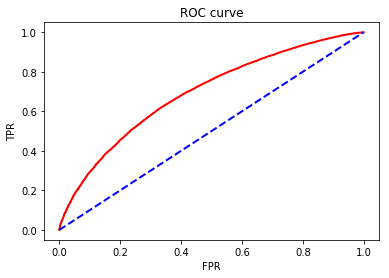

In [272]:
plot_roc(lr, x_test, y_test)

## Дерево решений (классификация)

In [273]:
from sklearn.tree import DecisionTreeClassifier

In [274]:
clf_tree = DecisionTreeClassifier(criterion='entropy',splitter = 'random', max_depth=12, random_state=42, min_samples_leaf = 3)
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random')

In [275]:
show_scores(clf_tree, x_test, y_test)

Recall: 0.96
Precision score: 0.79
Accuracy score: 0.77


ROC-AUC score:  0.6754340131251977


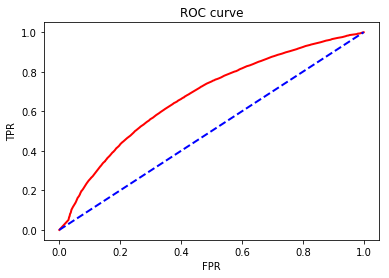

In [276]:
plot_roc(clf_tree, x_test, y_test)

## Случайный лес

In [277]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [278]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [12,10,8],
#    'min_samples_leaf': [1,3,5,7],
#    'n_estimators': [80,100,200,500],
#    'criterion' : ['entropy','gini'],
#}
#score = make_scorer(roc_auc_score)
#rf =  RandomForestClassifier(random_state = 42)
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 5, n_jobs = -1, verbose = 2, scoring=score)
#grid_search.fit(x_train,  y_train)
#grid_search.best_params_
# best_grid = grid_search.best_estimator_

In [279]:
best_grid = RandomForestClassifier(random_state = 42, bootstrap = True, 
                                   max_depth = 12, min_samples_leaf = 1,
                                   n_estimators = 80, criterion = 'entropy')
best_grid.fit(x_train,  y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [280]:
best_grid.predict(x_test)
show_scores(best_grid, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7088091643978713


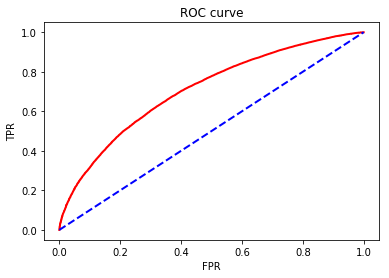

In [281]:
plot_roc(best_grid, x_test, y_test)

## VotingClassifier

In [282]:
from sklearn.ensemble import VotingClassifier

In [283]:
voting_clf = VotingClassifier(estimators=[('lr', lr), ('rf', best_grid)],voting='soft')
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...mators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [284]:
show_scores(voting_clf, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7062283982087683


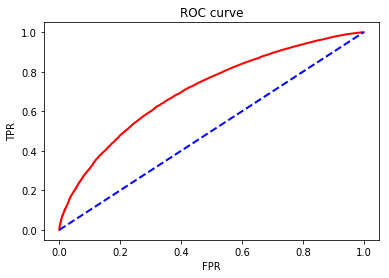

In [285]:
plot_roc(voting_clf, x_test, y_test)

## Xgboost (Grid search)

[Параметры XGBClassifier](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [60]:
import xgboost as xgb

In [61]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 25 columns):
annual_inc                             140132 non-null float64
dti                                    140132 non-null float64
home_ownership_MORTGAGE                140132 non-null uint8
home_ownership_OTHER                   140132 non-null uint8
home_ownership_OWN                     140132 non-null uint8
home_ownership_RENT                    140132 non-null uint8
inq_last_6mths                         140132 non-null float64
int_rate                               140132 non-null float64
loan_amnt                              140132 non-null float64
open_acc                               140132 non-null float64
purpose_credit_card                    140132 non-null uint8
purpose_debt_consolidation             140132 non-null uint8
purpose_home_improvement               140132 non-null uint8
purpose_other                          140132 non-null uint8
revol_bal         

In [62]:
xgbst = xgb.XGBClassifier(
                           max_depth=3,
                           min_child_weight=3, #Defines the minimum sum of weights of all observations required
                           gamma = 0.25, 
                                    #A node is split only when the resulting split gives a positive 
                                    #reduction in the loss function. Gamma specifies the minimum loss 
                                    #reduction required to make a split.in a child
                           eval_metric = 'auc',                         
                           subsample= 0.52,
                                    #Denotes the fraction of observations to be randomly sampled for each tree
                           colsample_bytree=0.95, #The number of features to consider while searching for the best split
                           reg_alpha= 5,# L1 regularization term on weights
                           reg_lambda=0,# L2 regularization term on weights.
                           learning_rate = 0.01,
                           n_estimators =4000,
                           objective='binary:logistic',
                           
                           verbosity  = 2, # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). 
                          
                           scale_pos_weight=1, #Control the balance of positive and negative weights, useful for unbalanced classes
                           seed=20,
                           random_state= 42,
                           missing=None)

In [63]:
xgbst.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, eval_metric='auc', gamma=0.25,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=5, reg_lambda=0, scale_pos_weight=1, seed=20, silent=True,
       subsample=0.52, verbosity=2)

In [68]:
show_scores(xgbst, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.733073972169614


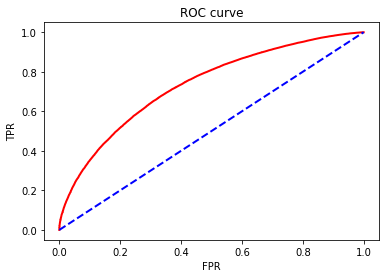

In [69]:
plot_roc(xgbst, x_test, y_test)

## Xgboost (Hypetopt)

In [223]:
from sklearn.metrics import r2_score
from hyperopt import tpe, hp, fmin
import xgboost as xgb
from hyperopt.mongoexp import MongoTrials

In [224]:
def func(args):
    loss = 0
    if args['model'] == xgb.XGBClassifier:
        max_depth = args['param']['max_depth']
        min_child_weight = args['param']['min_child_weight']
        gamma = args['param']['gamma']
        subsample = args['param']['subsample']
        colsample_bytree = args['param']['colsample_bytree']
        reg_alpha = args['param']['reg_alpha']
        clf = xgb.XGBClassifier(eval_metric = 'auc',
                               objective='binary:logistic',
                               verbosity  = 2,
                               random_state= 42,
                               learning_rate = 0.1,
                               n_estimators=1000,    
                               reg_lambda=0,
                               max_depth = max_depth,
                               min_child_weight =min_child_weight,
                               gamma =  gamma,
                               subsample = subsample,
                               colsample_bytree = colsample_bytree,
                               reg_alpha = reg_alpha)
        clf.fit(x_train,y_train)
        y_pred_train = clf.predict_proba(x_train)
        loss =  roc_auc_score(y_train, y_pred_train[:, 1])
        print("Test Score:",clf.score(x_test,y_test))
        print("Train Score:",clf.score(x_train,y_train))
        print("\n=================")
    return -loss


In [225]:
space = hp.choice('classifier',[
        {
        'model': xgb.XGBClassifier,
        'param': {
        'max_depth' : hp.choice('max_depth',range(3,10,2)),
        'min_child_weight' : hp.choice('min_child_weight', range(1,6,2)),
        'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
        'subsample' : hp.choice('subsample', [i/10.0 for i in range(6,10)]),
        'colsample_bytree'  : hp.choice('colsample_bytree', [i/10.0 for i in range(6,10)]),
        'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 100])  
        }}
        ])
space

In [226]:
# trials = MongoTrials('mongo://localhost:27017/foo_db/jobs',exp_key='exp1')

In [227]:
# best = fmin(func,space,algo=tpe.suggest,max_evals=100)
best = {'classifier': 0,
 'colsample_bytree': 1,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 0,
 'reg_alpha': 3,
 'subsample': 0}

In [228]:
best

{'classifier': 0,
 'colsample_bytree': 1,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 0,
 'reg_alpha': 3,
 'subsample': 0}

In [229]:
bst = xgb.XGBClassifier(     eval_metric = 'auc',
                               objective='binary:logistic',
                               verbosity  = 2,
                               random_state= 42,
                               learning_rate = 0.01,
                               n_estimators=4000,    
                               reg_lambda=0,
                               seed = 20,
                               max_depth = best['max_depth'],
                               min_child_weight = best['min_child_weight'],
                               gamma =  best['gamma'],
                               subsample = 0.52,
                               colsample_bytree = best['colsample_bytree'],
                               reg_alpha = best['reg_alpha'])

In [230]:
bst.fit(x_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields verification_status, term, purpose, home_ownership

In [ ]:
show_scores(bst, x_test, y_test)

In [ ]:
plot_roc(bst, x_test, y_test)

## Catboost

In [191]:
from hyperopt import tpe, hp, fmin
import hyperopt 

In [192]:
x['purpose'].value_counts()

debt_consolidation    117953
credit_card            39337
home_improvement       11855
other                  11304
major_purchase          4865
small_business          3757
car                     2813
medical                 2273
moving                  1645
wedding                 1451
house                   1272
vacation                1220
educational              244
renewable_energy         200
Name: purpose, dtype: int64

In [193]:
x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)

In [194]:
x['purpose'].value_counts()

debt_consolidation    117953
credit_card            39337
other                  31044
home_improvement       11855
Name: purpose, dtype: int64

In [195]:
x['home_ownership'].value_counts()

MORTGAGE    98279
RENT        84233
OWN         17542
OTHER         101
NONE           33
ANY             1
Name: home_ownership, dtype: int64

In [196]:
x['home_ownership'] = x['home_ownership'].astype(str).map(lambda x: 'OTHER' if x in ['NONE', 'ANY'] else x)

In [197]:
x['home_ownership'].value_counts()

MORTGAGE    98279
RENT        84233
OWN         17542
OTHER         135
Name: home_ownership, dtype: int64

In [198]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
# x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
# x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_test['sub_grade'] = x_test['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
x_train['sub_grade'] = x_train['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
# x_train = pd.get_dummies(x_train, columns = ['purpose','home_ownership'])   # OHE (?????)
# x_test = pd.get_dummies(x_test, columns = ['purpose','home_ownership'])
#for i in list(x_test): # удаление из тестовых данных столбцов, если их не было в тренировочных
#    if i not in list(x_train):
#        list(my_dataframe)
#        x_test.drop(i, axis=1, inplace=True)
#for i in list(x_train): # добавление колонки с нулями, если такой нет в тестовой
#    if i not in list(x_test):
#         x_test[i] = 0   

#x_test = x_test.reindex(sorted(x_test.columns), axis=1)
#x_train = x_train.reindex(sorted(x_test.columns), axis=1)

In [199]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 16 columns):
annual_inc             140132 non-null float64
verification_status    140132 non-null object
int_rate               140132 non-null float64
term                   140132 non-null object
open_acc               140132 non-null float64
total_acc              140132 non-null float64
dti                    140132 non-null float64
purpose                140132 non-null object
tot_cur_bal            140132 non-null float64
sub_grade              140132 non-null int64
home_ownership         140132 non-null object
inq_last_6mths         140132 non-null float64
total_rev_hi_lim       140132 non-null float64
revol_bal              140132 non-null float64
revol_util             140132 non-null float64
loan_amnt              140132 non-null float64
dtypes: float64(11), int64(1), object(4)
memory usage: 18.2+ MB


In [200]:
x_train.head()

,annual_inc,verification_status,int_rate,term,open_acc,total_acc,dti,purpose,tot_cur_bal,sub_grade,home_ownership,inq_last_6mths,total_rev_hi_lim,revol_bal,revol_util,loan_amnt
193136,75000.0,Source Verified,13.11,36 months,17.0,42.0,26.85,credit_card,223010.0,664,MORTGAGE,2.0,43599.0,38230.0,87.7,20475.0
27784,73000.0,Verified,15.99,36 months,18.0,38.0,16.47,debt_consolidation,230520.0,682,MORTGAGE,2.0,24100.0,9874.0,41.0,12000.0
157132,200000.0,Verified,8.90,36 months,14.0,37.0,13.50,debt_consolidation,488248.0,655,MORTGAGE,2.0,54800.0,34550.0,63.0,16000.0
81962,100000.0,Not Verified,15.33,36 months,17.0,36.0,20.48,debt_consolidation,-999.0,683,MORTGAGE,3.0,-999.0,88599.0,60.9,12000.0
161,65000.0,Verified,14.16,36 months,14.0,19.0,14.00,debt_consolidation,18270.0,672,RENT,2.0,25100.0,10948.0,43.6,10000.0


In [201]:
categorical_features_names = x_train.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'term', 'purpose', 'home_ownership'], dtype='object')

In [202]:
categorical_features_indices = [x_train.columns.get_loc(i) for i in categorical_features_names]
categorical_features_indices

[1, 3, 7, 10]

In [203]:
from catboost import CatBoostClassifier, Pool, cv
import catboost as cb
import frozendict
# roc_auc_score

In [220]:
params = {'learning_rate': 0.01,
          'depth': 8.0,
       #   'rsm': 0.8789580279825991,
          'l2_leaf_reg': 29.083288170330242,
          'task_type': 'CPU',
          'loss_function': 'Logloss',
          'eval_metric': 'AUC', 'od_type': 'Iter',
          'od_wait': 40,
          'custom_metric': ['AUC'],
          'iterations': 4000,
          'random_seed': 42}
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)


In [221]:
best_model_params = params.copy()
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

0:	test: 0.6824708	best: 0.6824708 (0)	total: 195ms	remaining: 13m
1:	test: 0.6858379	best: 0.6858379 (1)	total: 357ms	remaining: 11m 53s
2:	test: 0.6920776	best: 0.6920776 (2)	total: 553ms	remaining: 12m 17s
3:	test: 0.6930901	best: 0.6930901 (3)	total: 741ms	remaining: 12m 20s
4:	test: 0.6939511	best: 0.6939511 (4)	total: 946ms	remaining: 12m 35s
5:	test: 0.6941375	best: 0.6941375 (5)	total: 1.13s	remaining: 12m 32s
6:	test: 0.6944049	best: 0.6944049 (6)	total: 1.32s	remaining: 12m 31s
7:	test: 0.6952111	best: 0.6952111 (7)	total: 1.51s	remaining: 12m 35s
8:	test: 0.6956565	best: 0.6956565 (8)	total: 1.7s	remaining: 12m 34s
9:	test: 0.6963395	best: 0.6963395 (9)	total: 1.89s	remaining: 12m 34s
10:	test: 0.6967887	best: 0.6967887 (10)	total: 2.09s	remaining: 12m 38s
11:	test: 0.6970598	best: 0.6970598 (11)	total: 2.27s	remaining: 12m 34s
12:	test: 0.6972994	best: 0.6972994 (12)	total: 2.46s	remaining: 12m 34s
13:	test: 0.6965201	best: 0.6972994 (12)	total: 2.57s	remaining: 12m 12s
14:

113:	test: 0.7016357	best: 0.7016357 (113)	total: 20.4s	remaining: 11m 35s
114:	test: 0.7016898	best: 0.7016898 (114)	total: 20.6s	remaining: 11m 37s
115:	test: 0.7017577	best: 0.7017577 (115)	total: 20.9s	remaining: 11m 38s
116:	test: 0.7018464	best: 0.7018464 (116)	total: 21.1s	remaining: 11m 39s
117:	test: 0.7018957	best: 0.7018957 (117)	total: 21.3s	remaining: 11m 40s
118:	test: 0.7019438	best: 0.7019438 (118)	total: 21.5s	remaining: 11m 42s
119:	test: 0.7019430	best: 0.7019438 (118)	total: 21.8s	remaining: 11m 43s
120:	test: 0.7019096	best: 0.7019438 (118)	total: 21.9s	remaining: 11m 41s
121:	test: 0.7018807	best: 0.7019438 (118)	total: 22s	remaining: 11m 39s
122:	test: 0.7019402	best: 0.7019438 (118)	total: 22.2s	remaining: 11m 39s
123:	test: 0.7019492	best: 0.7019492 (123)	total: 22.3s	remaining: 11m 36s
124:	test: 0.7019910	best: 0.7019910 (124)	total: 22.5s	remaining: 11m 36s
125:	test: 0.7020315	best: 0.7020315 (125)	total: 22.6s	remaining: 11m 36s
126:	test: 0.7020432	best: 

223:	test: 0.7052989	best: 0.7052989 (223)	total: 40s	remaining: 11m 14s
224:	test: 0.7053209	best: 0.7053209 (224)	total: 40.2s	remaining: 11m 14s
225:	test: 0.7053623	best: 0.7053623 (225)	total: 40.4s	remaining: 11m 14s
226:	test: 0.7054044	best: 0.7054044 (226)	total: 40.6s	remaining: 11m 14s
227:	test: 0.7054281	best: 0.7054281 (227)	total: 40.8s	remaining: 11m 14s
228:	test: 0.7054590	best: 0.7054590 (228)	total: 40.9s	remaining: 11m 14s
229:	test: 0.7054665	best: 0.7054665 (229)	total: 41s	remaining: 11m 12s
230:	test: 0.7054980	best: 0.7054980 (230)	total: 41.2s	remaining: 11m 12s
231:	test: 0.7055233	best: 0.7055233 (231)	total: 41.5s	remaining: 11m 13s
232:	test: 0.7055513	best: 0.7055513 (232)	total: 41.7s	remaining: 11m 13s
233:	test: 0.7055838	best: 0.7055838 (233)	total: 41.9s	remaining: 11m 13s
234:	test: 0.7056154	best: 0.7056154 (234)	total: 42.1s	remaining: 11m 13s
235:	test: 0.7056340	best: 0.7056340 (235)	total: 42.2s	remaining: 11m 13s
236:	test: 0.7056557	best: 0.

334:	test: 0.7077946	best: 0.7077946 (334)	total: 1m	remaining: 11m 6s
335:	test: 0.7078159	best: 0.7078159 (335)	total: 1m 1s	remaining: 11m 6s
336:	test: 0.7078273	best: 0.7078273 (336)	total: 1m 1s	remaining: 11m 6s
337:	test: 0.7078502	best: 0.7078502 (337)	total: 1m 1s	remaining: 11m 6s
338:	test: 0.7078676	best: 0.7078676 (338)	total: 1m 1s	remaining: 11m 6s
339:	test: 0.7078848	best: 0.7078848 (339)	total: 1m 1s	remaining: 11m 6s
340:	test: 0.7078933	best: 0.7078933 (340)	total: 1m 2s	remaining: 11m 6s
341:	test: 0.7079115	best: 0.7079115 (341)	total: 1m 2s	remaining: 11m 6s
342:	test: 0.7079295	best: 0.7079295 (342)	total: 1m 2s	remaining: 11m 6s
343:	test: 0.7079448	best: 0.7079448 (343)	total: 1m 2s	remaining: 11m 6s
344:	test: 0.7079608	best: 0.7079608 (344)	total: 1m 2s	remaining: 11m 6s
345:	test: 0.7079777	best: 0.7079777 (345)	total: 1m 3s	remaining: 11m 6s
346:	test: 0.7079997	best: 0.7079997 (346)	total: 1m 3s	remaining: 11m 6s
347:	test: 0.7080173	best: 0.7080173 (347

444:	test: 0.7094305	best: 0.7094305 (444)	total: 1m 21s	remaining: 10m 50s
445:	test: 0.7094404	best: 0.7094404 (445)	total: 1m 21s	remaining: 10m 50s
446:	test: 0.7094526	best: 0.7094526 (446)	total: 1m 21s	remaining: 10m 49s
447:	test: 0.7094615	best: 0.7094615 (447)	total: 1m 21s	remaining: 10m 49s
448:	test: 0.7094684	best: 0.7094684 (448)	total: 1m 22s	remaining: 10m 49s
449:	test: 0.7094714	best: 0.7094714 (449)	total: 1m 22s	remaining: 10m 49s
450:	test: 0.7094889	best: 0.7094889 (450)	total: 1m 22s	remaining: 10m 49s
451:	test: 0.7095041	best: 0.7095041 (451)	total: 1m 22s	remaining: 10m 48s
452:	test: 0.7095136	best: 0.7095136 (452)	total: 1m 22s	remaining: 10m 48s
453:	test: 0.7095267	best: 0.7095267 (453)	total: 1m 23s	remaining: 10m 48s
454:	test: 0.7095349	best: 0.7095349 (454)	total: 1m 23s	remaining: 10m 48s
455:	test: 0.7095595	best: 0.7095595 (455)	total: 1m 23s	remaining: 10m 48s
456:	test: 0.7095653	best: 0.7095653 (456)	total: 1m 23s	remaining: 10m 48s
457:	test: 0

552:	test: 0.7104999	best: 0.7104999 (552)	total: 1m 41s	remaining: 10m 30s
553:	test: 0.7104994	best: 0.7104999 (552)	total: 1m 41s	remaining: 10m 29s
554:	test: 0.7105039	best: 0.7105039 (554)	total: 1m 41s	remaining: 10m 29s
555:	test: 0.7105163	best: 0.7105163 (555)	total: 1m 41s	remaining: 10m 28s
556:	test: 0.7105343	best: 0.7105343 (556)	total: 1m 41s	remaining: 10m 28s
557:	test: 0.7105391	best: 0.7105391 (557)	total: 1m 41s	remaining: 10m 28s
558:	test: 0.7105524	best: 0.7105524 (558)	total: 1m 42s	remaining: 10m 28s
559:	test: 0.7105664	best: 0.7105664 (559)	total: 1m 42s	remaining: 10m 28s
560:	test: 0.7105708	best: 0.7105708 (560)	total: 1m 42s	remaining: 10m 28s
561:	test: 0.7105740	best: 0.7105740 (561)	total: 1m 42s	remaining: 10m 27s
562:	test: 0.7105851	best: 0.7105851 (562)	total: 1m 42s	remaining: 10m 27s
563:	test: 0.7105970	best: 0.7105970 (563)	total: 1m 42s	remaining: 10m 27s
564:	test: 0.7106076	best: 0.7106076 (564)	total: 1m 43s	remaining: 10m 27s
565:	test: 0

660:	test: 0.7113080	best: 0.7113080 (660)	total: 2m	remaining: 10m 9s
661:	test: 0.7113149	best: 0.7113149 (661)	total: 2m	remaining: 10m 9s
662:	test: 0.7113180	best: 0.7113180 (662)	total: 2m 1s	remaining: 10m 9s
663:	test: 0.7113277	best: 0.7113277 (663)	total: 2m 1s	remaining: 10m 9s
664:	test: 0.7113367	best: 0.7113367 (664)	total: 2m 1s	remaining: 10m 8s
665:	test: 0.7113435	best: 0.7113435 (665)	total: 2m 1s	remaining: 10m 8s
666:	test: 0.7113512	best: 0.7113512 (666)	total: 2m 1s	remaining: 10m 8s
667:	test: 0.7113525	best: 0.7113525 (667)	total: 2m 1s	remaining: 10m 7s
668:	test: 0.7113568	best: 0.7113568 (668)	total: 2m 2s	remaining: 10m 7s
669:	test: 0.7113637	best: 0.7113637 (669)	total: 2m 2s	remaining: 10m 7s
670:	test: 0.7113692	best: 0.7113692 (670)	total: 2m 2s	remaining: 10m 7s
671:	test: 0.7113769	best: 0.7113769 (671)	total: 2m 2s	remaining: 10m 6s
672:	test: 0.7113841	best: 0.7113841 (672)	total: 2m 2s	remaining: 10m 6s
673:	test: 0.7113871	best: 0.7113871 (673)	t

771:	test: 0.7118772	best: 0.7118772 (771)	total: 2m 20s	remaining: 9m 45s
772:	test: 0.7118832	best: 0.7118832 (772)	total: 2m 20s	remaining: 9m 45s
773:	test: 0.7118953	best: 0.7118953 (773)	total: 2m 20s	remaining: 9m 45s
774:	test: 0.7119025	best: 0.7119025 (774)	total: 2m 20s	remaining: 9m 45s
775:	test: 0.7119074	best: 0.7119074 (775)	total: 2m 20s	remaining: 9m 45s
776:	test: 0.7119120	best: 0.7119120 (776)	total: 2m 21s	remaining: 9m 44s
777:	test: 0.7119214	best: 0.7119214 (777)	total: 2m 21s	remaining: 9m 44s
778:	test: 0.7119308	best: 0.7119308 (778)	total: 2m 21s	remaining: 9m 44s
779:	test: 0.7119362	best: 0.7119362 (779)	total: 2m 21s	remaining: 9m 44s
780:	test: 0.7119407	best: 0.7119407 (780)	total: 2m 21s	remaining: 9m 44s
781:	test: 0.7119438	best: 0.7119438 (781)	total: 2m 21s	remaining: 9m 44s
782:	test: 0.7119462	best: 0.7119462 (782)	total: 2m 22s	remaining: 9m 44s
783:	test: 0.7119530	best: 0.7119530 (783)	total: 2m 22s	remaining: 9m 43s
784:	test: 0.7119621	best

881:	test: 0.7123934	best: 0.7123934 (881)	total: 2m 39s	remaining: 9m 24s
882:	test: 0.7124026	best: 0.7124026 (882)	total: 2m 39s	remaining: 9m 24s
883:	test: 0.7124107	best: 0.7124107 (883)	total: 2m 40s	remaining: 9m 24s
884:	test: 0.7124145	best: 0.7124145 (884)	total: 2m 40s	remaining: 9m 23s
885:	test: 0.7124164	best: 0.7124164 (885)	total: 2m 40s	remaining: 9m 23s
886:	test: 0.7124226	best: 0.7124226 (886)	total: 2m 40s	remaining: 9m 23s
887:	test: 0.7124305	best: 0.7124305 (887)	total: 2m 40s	remaining: 9m 23s
888:	test: 0.7124378	best: 0.7124378 (888)	total: 2m 40s	remaining: 9m 23s
889:	test: 0.7124407	best: 0.7124407 (889)	total: 2m 41s	remaining: 9m 23s
890:	test: 0.7124470	best: 0.7124470 (890)	total: 2m 41s	remaining: 9m 22s
891:	test: 0.7124507	best: 0.7124507 (891)	total: 2m 41s	remaining: 9m 22s
892:	test: 0.7124530	best: 0.7124530 (892)	total: 2m 41s	remaining: 9m 22s
893:	test: 0.7124565	best: 0.7124565 (893)	total: 2m 41s	remaining: 9m 22s
894:	test: 0.7124602	best

991:	test: 0.7128218	best: 0.7128218 (991)	total: 2m 59s	remaining: 9m 4s
992:	test: 0.7128256	best: 0.7128256 (992)	total: 2m 59s	remaining: 9m 4s
993:	test: 0.7128276	best: 0.7128276 (993)	total: 3m	remaining: 9m 4s
994:	test: 0.7128297	best: 0.7128297 (994)	total: 3m	remaining: 9m 4s
995:	test: 0.7128328	best: 0.7128328 (995)	total: 3m	remaining: 9m 4s
996:	test: 0.7128346	best: 0.7128346 (996)	total: 3m	remaining: 9m 4s
997:	test: 0.7128348	best: 0.7128348 (997)	total: 3m	remaining: 9m 4s
998:	test: 0.7128415	best: 0.7128415 (998)	total: 3m 1s	remaining: 9m 3s
999:	test: 0.7128474	best: 0.7128474 (999)	total: 3m 1s	remaining: 9m 3s
1000:	test: 0.7128483	best: 0.7128483 (1000)	total: 3m 1s	remaining: 9m 3s
1001:	test: 0.7128510	best: 0.7128510 (1001)	total: 3m 1s	remaining: 9m 3s
1002:	test: 0.7128573	best: 0.7128573 (1002)	total: 3m 1s	remaining: 9m 3s
1003:	test: 0.7128589	best: 0.7128589 (1003)	total: 3m 1s	remaining: 9m 2s
1004:	test: 0.7128590	best: 0.7128590 (1004)	total: 3m 2

1100:	test: 0.7131313	best: 0.7131313 (1100)	total: 3m 19s	remaining: 8m 45s
1101:	test: 0.7131368	best: 0.7131368 (1101)	total: 3m 19s	remaining: 8m 44s
1102:	test: 0.7131369	best: 0.7131369 (1102)	total: 3m 19s	remaining: 8m 44s
1103:	test: 0.7131383	best: 0.7131383 (1103)	total: 3m 19s	remaining: 8m 44s
1104:	test: 0.7131385	best: 0.7131385 (1104)	total: 3m 20s	remaining: 8m 44s
1105:	test: 0.7131384	best: 0.7131385 (1104)	total: 3m 20s	remaining: 8m 44s
1106:	test: 0.7131419	best: 0.7131419 (1106)	total: 3m 20s	remaining: 8m 44s
1107:	test: 0.7131452	best: 0.7131452 (1107)	total: 3m 20s	remaining: 8m 44s
1108:	test: 0.7131536	best: 0.7131536 (1108)	total: 3m 21s	remaining: 8m 44s
1109:	test: 0.7131545	best: 0.7131545 (1109)	total: 3m 21s	remaining: 8m 44s
1110:	test: 0.7131597	best: 0.7131597 (1110)	total: 3m 21s	remaining: 8m 43s
1111:	test: 0.7131637	best: 0.7131637 (1111)	total: 3m 21s	remaining: 8m 43s
1112:	test: 0.7131649	best: 0.7131649 (1112)	total: 3m 21s	remaining: 8m 43s

1207:	test: 0.7135039	best: 0.7135039 (1207)	total: 3m 39s	remaining: 8m 27s
1208:	test: 0.7135123	best: 0.7135123 (1208)	total: 3m 39s	remaining: 8m 27s
1209:	test: 0.7135105	best: 0.7135123 (1208)	total: 3m 40s	remaining: 8m 27s
1210:	test: 0.7135135	best: 0.7135135 (1210)	total: 3m 40s	remaining: 8m 27s
1211:	test: 0.7135191	best: 0.7135191 (1211)	total: 3m 40s	remaining: 8m 27s
1212:	test: 0.7135209	best: 0.7135209 (1212)	total: 3m 40s	remaining: 8m 26s
1213:	test: 0.7135243	best: 0.7135243 (1213)	total: 3m 40s	remaining: 8m 26s
1214:	test: 0.7135247	best: 0.7135247 (1214)	total: 3m 41s	remaining: 8m 26s
1215:	test: 0.7135263	best: 0.7135263 (1215)	total: 3m 41s	remaining: 8m 26s
1216:	test: 0.7135252	best: 0.7135263 (1215)	total: 3m 41s	remaining: 8m 26s
1217:	test: 0.7135282	best: 0.7135282 (1217)	total: 3m 41s	remaining: 8m 26s
1218:	test: 0.7135331	best: 0.7135331 (1218)	total: 3m 41s	remaining: 8m 25s
1219:	test: 0.7135331	best: 0.7135331 (1219)	total: 3m 41s	remaining: 8m 25s

1314:	test: 0.7138395	best: 0.7138395 (1314)	total: 3m 59s	remaining: 8m 9s
1315:	test: 0.7138415	best: 0.7138415 (1315)	total: 3m 59s	remaining: 8m 9s
1316:	test: 0.7138442	best: 0.7138442 (1316)	total: 4m	remaining: 8m 8s
1317:	test: 0.7138487	best: 0.7138487 (1317)	total: 4m	remaining: 8m 8s
1318:	test: 0.7138566	best: 0.7138566 (1318)	total: 4m	remaining: 8m 8s
1319:	test: 0.7138597	best: 0.7138597 (1319)	total: 4m	remaining: 8m 8s
1320:	test: 0.7138617	best: 0.7138617 (1320)	total: 4m	remaining: 8m 8s
1321:	test: 0.7138607	best: 0.7138617 (1320)	total: 4m	remaining: 8m 8s
1322:	test: 0.7138630	best: 0.7138630 (1322)	total: 4m 1s	remaining: 8m 7s
1323:	test: 0.7138659	best: 0.7138659 (1323)	total: 4m 1s	remaining: 8m 7s
1324:	test: 0.7138699	best: 0.7138699 (1324)	total: 4m 1s	remaining: 8m 7s
1325:	test: 0.7138738	best: 0.7138738 (1325)	total: 4m 1s	remaining: 8m 7s
1326:	test: 0.7138801	best: 0.7138801 (1326)	total: 4m 1s	remaining: 8m 7s
1327:	test: 0.7138805	best: 0.7138805 (13

1423:	test: 0.7140878	best: 0.7140878 (1423)	total: 4m 19s	remaining: 7m 49s
1424:	test: 0.7140900	best: 0.7140900 (1424)	total: 4m 19s	remaining: 7m 49s
1425:	test: 0.7140908	best: 0.7140908 (1425)	total: 4m 19s	remaining: 7m 49s
1426:	test: 0.7140926	best: 0.7140926 (1426)	total: 4m 20s	remaining: 7m 49s
1427:	test: 0.7140961	best: 0.7140961 (1427)	total: 4m 20s	remaining: 7m 48s
1428:	test: 0.7140985	best: 0.7140985 (1428)	total: 4m 20s	remaining: 7m 48s
1429:	test: 0.7141014	best: 0.7141014 (1429)	total: 4m 20s	remaining: 7m 48s
1430:	test: 0.7141095	best: 0.7141095 (1430)	total: 4m 20s	remaining: 7m 48s
1431:	test: 0.7141138	best: 0.7141138 (1431)	total: 4m 21s	remaining: 7m 48s
1432:	test: 0.7141174	best: 0.7141174 (1432)	total: 4m 21s	remaining: 7m 47s
1433:	test: 0.7141209	best: 0.7141209 (1433)	total: 4m 21s	remaining: 7m 47s
1434:	test: 0.7141265	best: 0.7141265 (1434)	total: 4m 21s	remaining: 7m 47s
1435:	test: 0.7141283	best: 0.7141283 (1435)	total: 4m 21s	remaining: 7m 47s

1530:	test: 0.7143138	best: 0.7143159 (1529)	total: 4m 39s	remaining: 7m 30s
1531:	test: 0.7143212	best: 0.7143212 (1531)	total: 4m 39s	remaining: 7m 30s
1532:	test: 0.7143299	best: 0.7143299 (1532)	total: 4m 39s	remaining: 7m 29s
1533:	test: 0.7143297	best: 0.7143299 (1532)	total: 4m 39s	remaining: 7m 29s
1534:	test: 0.7143308	best: 0.7143308 (1534)	total: 4m 39s	remaining: 7m 29s
1535:	test: 0.7143320	best: 0.7143320 (1535)	total: 4m 40s	remaining: 7m 29s
1536:	test: 0.7143318	best: 0.7143320 (1535)	total: 4m 40s	remaining: 7m 29s
1537:	test: 0.7143346	best: 0.7143346 (1537)	total: 4m 40s	remaining: 7m 28s
1538:	test: 0.7143341	best: 0.7143346 (1537)	total: 4m 40s	remaining: 7m 28s
1539:	test: 0.7143363	best: 0.7143363 (1539)	total: 4m 40s	remaining: 7m 28s
1540:	test: 0.7143359	best: 0.7143363 (1539)	total: 4m 40s	remaining: 7m 28s
1541:	test: 0.7143353	best: 0.7143363 (1539)	total: 4m 41s	remaining: 7m 28s
1542:	test: 0.7143353	best: 0.7143363 (1539)	total: 4m 41s	remaining: 7m 27s

1637:	test: 0.7144429	best: 0.7144429 (1637)	total: 4m 58s	remaining: 7m 10s
1638:	test: 0.7144425	best: 0.7144429 (1637)	total: 4m 58s	remaining: 7m 10s
1639:	test: 0.7144391	best: 0.7144429 (1637)	total: 4m 58s	remaining: 7m 10s
1640:	test: 0.7144432	best: 0.7144432 (1640)	total: 4m 59s	remaining: 7m 10s
1641:	test: 0.7144452	best: 0.7144452 (1641)	total: 4m 59s	remaining: 7m 9s
1642:	test: 0.7144447	best: 0.7144452 (1641)	total: 4m 59s	remaining: 7m 9s
1643:	test: 0.7144449	best: 0.7144452 (1641)	total: 4m 59s	remaining: 7m 9s
1644:	test: 0.7144436	best: 0.7144452 (1641)	total: 4m 59s	remaining: 7m 9s
1645:	test: 0.7144474	best: 0.7144474 (1645)	total: 5m	remaining: 7m 9s
1646:	test: 0.7144497	best: 0.7144497 (1646)	total: 5m	remaining: 7m 8s
1647:	test: 0.7144496	best: 0.7144497 (1646)	total: 5m	remaining: 7m 8s
1648:	test: 0.7144528	best: 0.7144528 (1648)	total: 5m	remaining: 7m 8s
1649:	test: 0.7144524	best: 0.7144528 (1648)	total: 5m	remaining: 7m 8s
1650:	test: 0.7144536	best: 

1746:	test: 0.7146154	best: 0.7146154 (1746)	total: 5m 19s	remaining: 6m 51s
1747:	test: 0.7146230	best: 0.7146230 (1747)	total: 5m 19s	remaining: 6m 51s
1748:	test: 0.7146221	best: 0.7146230 (1747)	total: 5m 19s	remaining: 6m 51s
1749:	test: 0.7146218	best: 0.7146230 (1747)	total: 5m 19s	remaining: 6m 50s
1750:	test: 0.7146283	best: 0.7146283 (1750)	total: 5m 19s	remaining: 6m 50s
1751:	test: 0.7146281	best: 0.7146283 (1750)	total: 5m 20s	remaining: 6m 50s
1752:	test: 0.7146282	best: 0.7146283 (1750)	total: 5m 20s	remaining: 6m 50s
1753:	test: 0.7146301	best: 0.7146301 (1753)	total: 5m 20s	remaining: 6m 50s
1754:	test: 0.7146314	best: 0.7146314 (1754)	total: 5m 20s	remaining: 6m 50s
1755:	test: 0.7146330	best: 0.7146330 (1755)	total: 5m 20s	remaining: 6m 49s
1756:	test: 0.7146293	best: 0.7146330 (1755)	total: 5m 20s	remaining: 6m 49s
1757:	test: 0.7146342	best: 0.7146342 (1757)	total: 5m 21s	remaining: 6m 49s
1758:	test: 0.7146350	best: 0.7146350 (1758)	total: 5m 21s	remaining: 6m 49s

1853:	test: 0.7147252	best: 0.7147270 (1850)	total: 5m 38s	remaining: 6m 32s
1854:	test: 0.7147272	best: 0.7147272 (1854)	total: 5m 39s	remaining: 6m 32s
1855:	test: 0.7147295	best: 0.7147295 (1855)	total: 5m 39s	remaining: 6m 32s
1856:	test: 0.7147286	best: 0.7147295 (1855)	total: 5m 39s	remaining: 6m 31s
1857:	test: 0.7147297	best: 0.7147297 (1857)	total: 5m 39s	remaining: 6m 31s
1858:	test: 0.7147280	best: 0.7147297 (1857)	total: 5m 39s	remaining: 6m 31s
1859:	test: 0.7147300	best: 0.7147300 (1859)	total: 5m 40s	remaining: 6m 31s
1860:	test: 0.7147297	best: 0.7147300 (1859)	total: 5m 40s	remaining: 6m 31s
1861:	test: 0.7147309	best: 0.7147309 (1861)	total: 5m 40s	remaining: 6m 30s
1862:	test: 0.7147321	best: 0.7147321 (1862)	total: 5m 40s	remaining: 6m 30s
1863:	test: 0.7147334	best: 0.7147334 (1863)	total: 5m 40s	remaining: 6m 30s
1864:	test: 0.7147329	best: 0.7147334 (1863)	total: 5m 41s	remaining: 6m 30s
1865:	test: 0.7147353	best: 0.7147353 (1865)	total: 5m 41s	remaining: 6m 30s

1960:	test: 0.7148285	best: 0.7148353 (1941)	total: 5m 58s	remaining: 6m 13s
1961:	test: 0.7148286	best: 0.7148353 (1941)	total: 5m 58s	remaining: 6m 12s
1962:	test: 0.7148308	best: 0.7148353 (1941)	total: 5m 59s	remaining: 6m 12s
1963:	test: 0.7148324	best: 0.7148353 (1941)	total: 5m 59s	remaining: 6m 12s
1964:	test: 0.7148356	best: 0.7148356 (1964)	total: 5m 59s	remaining: 6m 12s
1965:	test: 0.7148355	best: 0.7148356 (1964)	total: 5m 59s	remaining: 6m 12s
1966:	test: 0.7148345	best: 0.7148356 (1964)	total: 5m 59s	remaining: 6m 11s
1967:	test: 0.7148325	best: 0.7148356 (1964)	total: 6m	remaining: 6m 11s
1968:	test: 0.7148345	best: 0.7148356 (1964)	total: 6m	remaining: 6m 11s
1969:	test: 0.7148357	best: 0.7148357 (1969)	total: 6m	remaining: 6m 11s
1970:	test: 0.7148352	best: 0.7148357 (1969)	total: 6m	remaining: 6m 11s
1971:	test: 0.7148354	best: 0.7148357 (1969)	total: 6m	remaining: 6m 11s
1972:	test: 0.7148369	best: 0.7148369 (1972)	total: 6m 1s	remaining: 6m 10s
1973:	test: 0.714834

2069:	test: 0.7149389	best: 0.7149395 (2068)	total: 6m 20s	remaining: 5m 54s
2070:	test: 0.7149401	best: 0.7149401 (2070)	total: 6m 20s	remaining: 5m 54s
2071:	test: 0.7149460	best: 0.7149460 (2071)	total: 6m 20s	remaining: 5m 54s
2072:	test: 0.7149490	best: 0.7149490 (2072)	total: 6m 20s	remaining: 5m 53s
2073:	test: 0.7149494	best: 0.7149494 (2073)	total: 6m 20s	remaining: 5m 53s
2074:	test: 0.7149487	best: 0.7149494 (2073)	total: 6m 21s	remaining: 5m 53s
2075:	test: 0.7149464	best: 0.7149494 (2073)	total: 6m 21s	remaining: 5m 53s
2076:	test: 0.7149473	best: 0.7149494 (2073)	total: 6m 21s	remaining: 5m 53s
2077:	test: 0.7149485	best: 0.7149494 (2073)	total: 6m 21s	remaining: 5m 52s
2078:	test: 0.7149466	best: 0.7149494 (2073)	total: 6m 21s	remaining: 5m 52s
2079:	test: 0.7149514	best: 0.7149514 (2079)	total: 6m 21s	remaining: 5m 52s
2080:	test: 0.7149547	best: 0.7149547 (2080)	total: 6m 22s	remaining: 5m 52s
2081:	test: 0.7149594	best: 0.7149594 (2081)	total: 6m 22s	remaining: 5m 52s

2176:	test: 0.7150194	best: 0.7150248 (2168)	total: 6m 40s	remaining: 5m 35s
2177:	test: 0.7150176	best: 0.7150248 (2168)	total: 6m 41s	remaining: 5m 35s
2178:	test: 0.7150168	best: 0.7150248 (2168)	total: 6m 41s	remaining: 5m 35s
2179:	test: 0.7150170	best: 0.7150248 (2168)	total: 6m 41s	remaining: 5m 35s
2180:	test: 0.7150162	best: 0.7150248 (2168)	total: 6m 41s	remaining: 5m 34s
2181:	test: 0.7150178	best: 0.7150248 (2168)	total: 6m 41s	remaining: 5m 34s
2182:	test: 0.7150175	best: 0.7150248 (2168)	total: 6m 41s	remaining: 5m 34s
2183:	test: 0.7150202	best: 0.7150248 (2168)	total: 6m 42s	remaining: 5m 34s
2184:	test: 0.7150226	best: 0.7150248 (2168)	total: 6m 42s	remaining: 5m 34s
2185:	test: 0.7150265	best: 0.7150265 (2185)	total: 6m 42s	remaining: 5m 33s
2186:	test: 0.7150236	best: 0.7150265 (2185)	total: 6m 42s	remaining: 5m 33s
2187:	test: 0.7150226	best: 0.7150265 (2185)	total: 6m 42s	remaining: 5m 33s
2188:	test: 0.7150220	best: 0.7150265 (2185)	total: 6m 43s	remaining: 5m 33s

2283:	test: 0.7150573	best: 0.7150687 (2275)	total: 7m	remaining: 5m 16s
2284:	test: 0.7150559	best: 0.7150687 (2275)	total: 7m	remaining: 5m 15s
2285:	test: 0.7150568	best: 0.7150687 (2275)	total: 7m 1s	remaining: 5m 15s
2286:	test: 0.7150577	best: 0.7150687 (2275)	total: 7m 1s	remaining: 5m 15s
2287:	test: 0.7150609	best: 0.7150687 (2275)	total: 7m 1s	remaining: 5m 15s
2288:	test: 0.7150606	best: 0.7150687 (2275)	total: 7m 1s	remaining: 5m 15s
2289:	test: 0.7150589	best: 0.7150687 (2275)	total: 7m 1s	remaining: 5m 15s
2290:	test: 0.7150589	best: 0.7150687 (2275)	total: 7m 1s	remaining: 5m 14s
2291:	test: 0.7150587	best: 0.7150687 (2275)	total: 7m 2s	remaining: 5m 14s
2292:	test: 0.7150602	best: 0.7150687 (2275)	total: 7m 2s	remaining: 5m 14s
2293:	test: 0.7150651	best: 0.7150687 (2275)	total: 7m 2s	remaining: 5m 14s
2294:	test: 0.7150655	best: 0.7150687 (2275)	total: 7m 2s	remaining: 5m 14s
2295:	test: 0.7150647	best: 0.7150687 (2275)	total: 7m 2s	remaining: 5m 13s
2296:	test: 0.7150

2392:	test: 0.7151050	best: 0.7151124 (2385)	total: 7m 21s	remaining: 4m 56s
2393:	test: 0.7151059	best: 0.7151124 (2385)	total: 7m 21s	remaining: 4m 56s
2394:	test: 0.7151077	best: 0.7151124 (2385)	total: 7m 21s	remaining: 4m 56s
2395:	test: 0.7151074	best: 0.7151124 (2385)	total: 7m 22s	remaining: 4m 55s
2396:	test: 0.7151064	best: 0.7151124 (2385)	total: 7m 22s	remaining: 4m 55s
2397:	test: 0.7151101	best: 0.7151124 (2385)	total: 7m 22s	remaining: 4m 55s
2398:	test: 0.7151126	best: 0.7151126 (2398)	total: 7m 22s	remaining: 4m 55s
2399:	test: 0.7151127	best: 0.7151127 (2399)	total: 7m 22s	remaining: 4m 55s
2400:	test: 0.7151134	best: 0.7151134 (2400)	total: 7m 23s	remaining: 4m 55s
2401:	test: 0.7151118	best: 0.7151134 (2400)	total: 7m 23s	remaining: 4m 54s
2402:	test: 0.7151118	best: 0.7151134 (2400)	total: 7m 23s	remaining: 4m 54s
2403:	test: 0.7151126	best: 0.7151134 (2400)	total: 7m 23s	remaining: 4m 54s
2404:	test: 0.7151123	best: 0.7151134 (2400)	total: 7m 23s	remaining: 4m 54s

In [231]:
show_scores(best_model, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7151536095505024


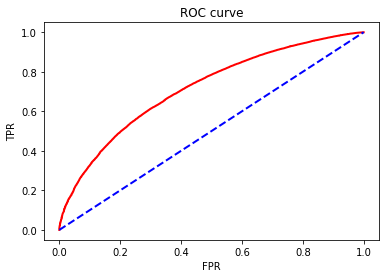

In [232]:
plot_roc(best_model, x_test, y_test)

In [219]:
feature_importances = best_model.get_feature_importance(train_pool)
feature_names = x_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

int_rate: 10.842444670547923
annual_inc: 10.088759113957005
loan_amnt: 8.279886924555411
dti: 7.8508731720555875
tot_cur_bal: 7.006539382859564
sub_grade: 6.942271014662915
revol_util: 6.437547406694622
total_rev_hi_lim: 5.9645194974492295
revol_bal: 5.936602640278861
total_acc: 5.224643538736965
open_acc: 5.144554488639059
verification_status: 4.873976629243489
term: 4.5950183692320286
purpose: 4.391734759509351
inq_last_6mths: 3.345470899450882
home_ownership: 3.0751574921270697


In [52]:
# make it True if your want to use GPU for training
have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False
# number of iterations of hyper-parameter search
hyperopt_iterations = 50

In [53]:
const_params = frozendict.frozendict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'od_type': 'Iter',
    'od_wait': 40,
    'custom_metric': ['AUC'],
    'iterations': 400,
    'random_seed':42})

In [54]:
class UciAdultClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'rsm' :  hyper_params['rsm'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg']}

    def __call__(self, hyper_params):
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()        
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=42,
            verbose=False)
        min_mean_auc = np.min(scores['test-AUC-mean'])
        print('evaluated score={}'.format(min_mean_auc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -min_mean_auc, 'status': hyperopt.STATUS_OK}

In [55]:

def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'depth': hp.quniform("depth", 4, 10, 1),
        'rsm': hp.uniform ('rsm', 0.75, 1.0),
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.2, 1.0),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.01, 100)}
 
    objective = UciAdultClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=42))
    return best

def train_best_model(dataset, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization  
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params



In [ ]:
model, params = train_best_model(
    train_pool, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)

evaluating params={'learning_rate': 0.8661056258519679, 'depth': 6.0, 'rsm': 0.863675263055343, 'l2_leaf_reg': 6.914443573951684, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6739634197140681                                                                                     
evaluated 1 times                                                                                                      
evaluating params={'learning_rate': 0.7821805945418601, 'depth': 6.0, 'rsm': 0.8525259897133284, 'l2_leaf_reg': 93.28747120479488, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6751068015558621                                                                                     
evaluated 2 times                          

In [261]:
params

{'depth': 7.0,
 'l2_leaf_reg': 4.2312063872926355,
 'learning_rate': 0.29621731293760284,
 'rsm': 0.904269839625579,
 'task_type': 'CPU',
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'od_type': 'Iter',
 'od_wait': 40,
 'custom_metric': ['AUC'],
 'iterations': 400,
 'random_seed': 42}

ROC-AUC score:  0.699669049459066


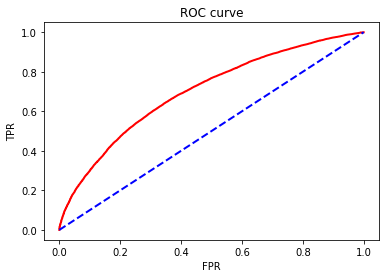

In [262]:
plot_roc(model, x_test, y_test)

In [263]:
show_scores(model, x_test, y_test)

Recall: 0.96
Precision score: 0.80
Accuracy score: 0.78


## LightGBM

In [33]:
import lightgbm as lgb

In [149]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
categorical_columns = x.columns[x.dtypes == 'object']
categorical_columns

Index(['initial_list_status', 'purpose', 'grade', 'home_ownership',
       'application_type'],
      dtype='object')

In [154]:
x_train['purpose'].value_counts()

debt_consolidation    82494
credit_card           27517
home_improvement       8322
other                  7876
major_purchase         3443
small_business         2665
car                    1964
medical                1589
moving                 1163
wedding                1028
house                   895
vacation                856
educational             182
renewable_energy        138
Name: purpose, dtype: int64

In [140]:
x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_train['application_type'] = x_train['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_test['application_type'] = x_test['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
categorical_columns = x.columns[x.dtypes == 'object']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 19 columns):
annual_inc                    140132 non-null float64
int_rate                      140132 non-null float64
collections_12_mths_ex_med    140132 non-null float64
initial_list_status           140132 non-null bool
installment                   140132 non-null float64
open_acc                      140132 non-null float64
total_acc                     140132 non-null float64
dti                           140132 non-null float64
purpose                       140132 non-null object
grade                         140132 non-null object
home_ownership                140132 non-null object
inq_last_6mths                140132 non-null float64
pub_rec                       140132 non-null float64
revol_bal                     140132 non-null float64
revol_util                    140132 non-null float64
tot_coll_amt                  140132 non-null float64
loan_amnt                 

In [127]:
params = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 20,
    'max_depth' : 6,
    'max_bin':100,
    'learning_rate':  0.35,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1' : 32,
    'verbose': 0}

In [128]:
params

{'boosting_type': 'dart',
 'objective': 'binary',
 'metric': {'auc'},
 'num_leaves': 20,
 'max_depth': 6,
 'max_bin': 100,
 'learning_rate': 0.35,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'lambda_l1': 32,
 'verbose': 0}

In [129]:
x_train.head()

,acc_now_delinq,annual_inc,application_type,collections_12_mths_ex_med,dti,grade_A,grade_B,grade_C,grade_D,grade_E,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,revol_bal,revol_util,tot_coll_amt,total_acc
193136,0.0,75000.0,True,0.0,26.85,0,1,0,0,0,...,0,0,0,0,0,0,38230.0,87.7,0.0,42.0
27784,0.0,73000.0,True,0.0,16.47,0,0,0,1,0,...,0,0,0,0,0,0,9874.0,41.0,0.0,38.0
157132,0.0,200000.0,True,0.0,13.50,1,0,0,0,0,...,0,0,0,0,0,0,34550.0,63.0,0.0,37.0
81962,0.0,100000.0,True,0.0,20.48,0,0,0,1,0,...,0,0,0,0,0,0,88599.0,60.9,0.0,36.0
161,0.0,65000.0,True,0.0,14.00,0,0,1,0,0,...,0,0,0,0,0,0,10948.0,43.6,0.0,19.0


In [130]:
lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train, free_raw_data=False)

In [131]:
evals_result = {}

In [132]:
num_train, num_feature = x_train.shape
feature_name = ['feature_' + str(col) for col in range(num_feature)]

In [133]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=[lgb_train, lgb_eval],
               # feature_name=feature_name,              
              #  categorical_feature= categorical_features_indices,
             #   learning_rates=lambda iter: 0.05 * (0.99 ** iter),
                evals_result=evals_result,
                verbose_eval=100)

[100]	training's auc: 0.720699	valid_1's auc: 0.708299
[200]	training's auc: 0.726036	valid_1's auc: 0.709584
[300]	training's auc: 0.730732	valid_1's auc: 0.710076
[400]	training's auc: 0.734714	valid_1's auc: 0.71066
[500]	training's auc: 0.738471	valid_1's auc: 0.710405
[600]	training's auc: 0.739775	valid_1's auc: 0.710752
[700]	training's auc: 0.742352	valid_1's auc: 0.711178
[800]	training's auc: 0.744439	valid_1's auc: 0.710858
[900]	training's auc: 0.746693	valid_1's auc: 0.710874
[1000]	training's auc: 0.748546	valid_1's auc: 0.710658
[1100]	training's auc: 0.750315	valid_1's auc: 0.709928
[1200]	training's auc: 0.751638	valid_1's auc: 0.709708
[1300]	training's auc: 0.75301	valid_1's auc: 0.709218
[1400]	training's auc: 0.755273	valid_1's auc: 0.708481
[1500]	training's auc: 0.756091	valid_1's auc: 0.708636
[1600]	training's auc: 0.757775	valid_1's auc: 0.708289
[1700]	training's auc: 0.759684	valid_1's auc: 0.708028
[1800]	training's auc: 0.761302	valid_1's auc: 0.707554
[19

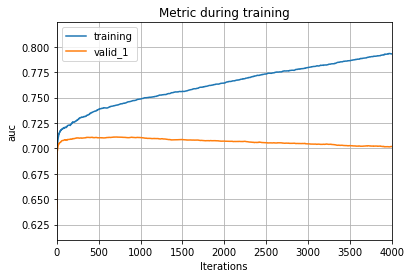

In [134]:
lgb.plot_metric(evals_result, metric='auc')
plt.show()